In [1]:
import numpy as np
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm, colors

import glob
import gc
import warnings
import copy
import pathlib
import pickle

import os
import shutil

from scipy import stats
import signac
import freud
import gsd.hoomd
import hoomd
import schmeud
import schmeud._schmeud as schmeud_rs
from schmeud._schmeud import statics
from schmeud._schmeud import locality
from schmeud import ml
from tqdm import tqdm

from dataclasses import dataclass
from collections import defaultdict

from numba import njit

In [2]:
from monk import nb, prep as prep_mod, pair, render, utils, workflow, grid

parent = pathlib.Path(os.getcwd()).parent / "config.yaml"
config = workflow.get_config(parent.as_posix())
parent, config

(PosixPath('/home/ian/Projects/work/monk/workflows/2d-osc-shear/config.yaml'),
 {'root': '/media/ian/Data2/monk/2d-osc-shear',
  'origin': '/media/ian/Data2/monk/2d-esl'})

In [3]:
project: signac.Project = signac.get_project(root=config['root'])
project.doc

{'avail_seed': 18, 'dt': 0.005, 'step_unit': 200, 'equil_time': 100, 'min_periods': 20, 'dumps': 40, 'period_times': [30.0, 100.0, 300.0, 1000.0], 'max_shears': [0.01, 0.02, 0.03, 0.05, 0.08, 0.12], '_status': {}}

In [4]:
@dataclass(frozen=True, eq=True)
class Statepoint:
    max_shear: float
    period: float
    temp: float
    prep: str

In [6]:
# let's look at the softess distributions when normalized

In [5]:
class InteractionComputer:

    def _setup_nve_sim(self, pot, dt=0.01):
        if isinstance(pot, str):
            pot = [pot]
        elif isinstance(pot, list):
            pass
        else:
            raise ValueError("The 'potential' must be a string or list")

        integrator = hoomd.md.Integrator(dt=dt)
        pair_func, args = prep_mod.search_for_pair(pot)
        tree = hoomd.md.nlist.Tree(0.3)
        print("Using pair function: ", pair_func)
        force = pair_func(tree, *args)

        nvt = hoomd.md.methods.NVE(hoomd.filter.All())
        integrator.forces = [force]
        integrator.methods = [nvt]

        self._sim.operations.integrator = integrator

        self._nlist = tree

        return nvt

    def __init__(self, filename, pot, frame=0, device=None, seed=None):
        if device is None:
            device = hoomd.device.CPU()
        sim = hoomd.Simulation(device, seed=seed)
        sim.create_state_from_gsd(filename, frame=frame)
        self._sim = sim
        self._file_handle = gsd.hoomd.open(name=filename, mode='rb')

        self._setup_nve_sim(pot)

        self._sim.always_compute_pressure = True

        self._snap = None

        sim.run(0)

    def get_forces(self):
        assert len(self._sim.operations.integrator.forces) == 1
        self._sim.run(0)
        return self._sim.operations.integrator.forces[0].forces
    
    def get_virials(self):
        assert len(self._sim.operations.integrator.forces) == 1
        self._sim.run(0)
        return self._sim.operations.integrator.forces[0].virials
    
    def get_pairs(self):
        self._sim.run(0)
        return self._nlist.pair_list()
    
    def get_snapshot(self):
        if self._snap is None or self._sim.timestep != self._snap.configuration.step:
            self._snap = self._sim.state.get_snapshot()
        return self._snap

    def get_positions(self):
        snap = self.get_snapshot()
        return snap.positions
    
    def get_box(self):
        return self._sim.state.box

    def set_frame(self, frame):
        snap = self._file_handle[frame]
        snap = hoomd.Snapshot.from_gsd_snapshot(snap, hoomd.communicator.Communicator())
        self._sim.state.set_snapshot(snap)

    def set_file(self, filename, frame=0):
        self._file_handle = gsd.hoomd.open(name=filename, mode='rb')
        self.set_frame(frame)

In [6]:
vmin = 0
vmax = 5
norm = colors.Normalize(vmin=vmin, vmax=vmax)
# norm = colors.LogNorm(vmin=vmin, vmax=vmax)
# mshear = 0.08

In [7]:
def clear_fig_and_plot_grid(ax, grid, norm, mshear, prep, colorbar=True, name=""):
    ax.clear()
    flip = grid.T
    # fig, ax = plt.subplots(figsize=(5, 4))
    cb = ax.matshow(flip, norm=norm, cmap="viridis")
    plt.title(f"prep={prep}   strain={mshear*100:.0f}%")
    if colorbar:
        plt.colorbar(cb, label=name)

634e14bc75836df75158fb15f379d8bb
7ec2f6aca035e69077eab24383a21cb6
ESL
Using pair function:  <function KA_LJ at 0x7fe5a4c7fac0>


100%|██████████| 201/201 [00:53<00:00,  3.75it/s]
ffmpeg version 4.2.2 Copyright (c) 2000-2019 the FFmpeg developers
  built with gcc 7.3.0 (crosstool-NG 1.23.0.449-a04d0)
  configuration: --prefix=/tmp/build/80754af9/ffmpeg_1587154242452/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placeho --cc=/tmp/build/80754af9/ffmpeg_1587154242452/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --enable-avresample --enable-gmp --enable-hardcoded-tables --enable-libfreetype --enable-libvpx --enable-pthreads --enable-libopus --enable-postproc --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame --disable-nonfree --enable-gpl --enable-gnutls --disable-openssl --enable-libopenh264 --enable-libx264
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58

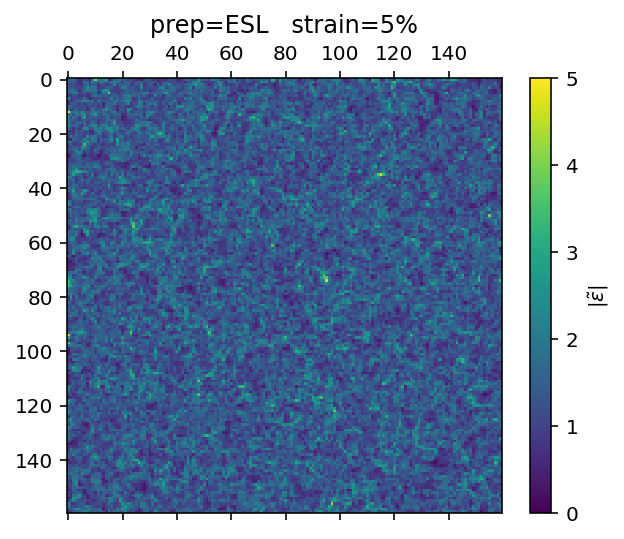

In [33]:
output = defaultdict(list)

fig, ax = plt.subplots(figsize=(5, 4))
colorbar = True

for job in project:
    print(job)
    prep = job.sp["prep"]
    if prep != "ESL":
        continue
    print(prep)
    txt_prep = prep.lower()
    
    experiments = sorted(glob.glob(job.fn("aqs_therm_experiments/*/*/traj-fire_period-*.gsd")))
    inter_computer = InteractionComputer(experiments[0], job.sp["pot"], frame=0)
    if len(experiments) == 0:
        continue
    for exper in experiments:
        max_shear = utils.extract_between(exper, "max-shear-", "/")
        period = utils.extract_between(exper, "period-", ".gsd")
        temp = utils.extract_between(exper, "temp-", "/")
        df_path = f"aqs_therm_experiments/max-shear-{max_shear}/temp-{temp}/final-cycles-softness_period-{period}.parquet"
        sp = Statepoint(max_shear=float(max_shear), period=float(period), temp=float(temp), prep=prep)
        
        if float(period) != 1000.0 or float(temp) > 5e-3 or float(max_shear) != 0.05:
            continue

        if job.isfile(df_path):
            dataset = pl.read_parquet(job.fn(df_path), use_pyarrow=True)
        else:
            continue

        inter_computer.set_file(exper, frame=0)

        traj = gsd.hoomd.open(exper, "rb")

        old_frames = glob.glob(job.fn(f"videos/dev-stress-mag-movie/dev-stress-mag-movie-*.png"))
        for f in old_frames:
            os.remove(f)

        output_file = f"videos/dev-stress-mag-movie-{txt_prep}_max-shear-{max_shear}_id-{job.id}.mp4"
        if os.path.exists(output_file):
            continue
        os.makedirs(job.fn("videos/dev-stress-mag-movie"), exist_ok=True)

        name = r"$|\tilde{\epsilon}|$"

        for frame, _, soft in tqdm(dataset.rows()[:]):
            frame
            soft = np.array(soft)
            snap = traj[frame]
            box = snap.configuration.box
            square_box = np.array([box[0], box[1], 0, 0, 0, 0])
            freud_box = freud.box.Box.from_box(square_box)
            pos = freud_box.wrap(snap.particles.position)

            inter_computer.set_frame(frame)
            virials = inter_computer.get_virials()
            #virial_trace = virials[:, 0] + virials[:, 3]
            # virial_trace = virials[:, 1]
            xx = virials[:, 0]
            yy = virials[:, 3]
            xy = virials[:, 1]
            diff = (xx - yy)/2
            virial_trace = np.sqrt(xy**2 + diff**2)  # deviatoric stress magnitude

            # norm = colors.Normalize(vmin=np.min(virial_trace), vmax=np.max(virial_trace))

            dev_stress_mag = locality.particle_to_grid_square_cic(
                pos[:, :2],
                virial_trace.astype(np.float32),
                box[0],
                160
            )

            clear_fig_and_plot_grid(ax, dev_stress_mag, norm, float(max_shear), prep, colorbar, name)
            output_name = job.fn(f"videos/dev-stress-mag-movie/dev-stress-mag-movie-{frame:04d}.png")
            colorbar = False

            plt.savefig(output_name, dpi=150)

        import ffmpeg
        (
        ffmpeg
            .input(job.fn("videos/dev-stress-mag-movie/dev-stress-mag-movie-*.png"), pattern_type="glob", framerate=10)
            .output(output_file).run()
        )
    break

In [34]:
np.min(virial_trace), np.max(virial_trace)

(0.002601748698075901, 6.10901881512043)

In [44]:
vmin = 0
vmax = 1
norm = colors.Normalize(vmin=vmin, vmax=vmax)
# vmin = 1e-2
# norm = colors.LogNorm(vmin=vmin, vmax=vmax)
# mshear = 0.08

634e14bc75836df75158fb15f379d8bb
HTL
Using pair function:  <function KA_LJ at 0x7fe5a4c7fac0>


100%|██████████| 201/201 [00:49<00:00,  4.03it/s]
ffmpeg version 4.2.2 Copyright (c) 2000-2019 the FFmpeg developers
  built with gcc 7.3.0 (crosstool-NG 1.23.0.449-a04d0)
  configuration: --prefix=/tmp/build/80754af9/ffmpeg_1587154242452/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placeho --cc=/tmp/build/80754af9/ffmpeg_1587154242452/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --enable-avresample --enable-gmp --enable-hardcoded-tables --enable-libfreetype --enable-libvpx --enable-pthreads --enable-libopus --enable-postproc --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame --disable-nonfree --enable-gpl --enable-gnutls --disable-openssl --enable-libopenh264 --enable-libx264
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58

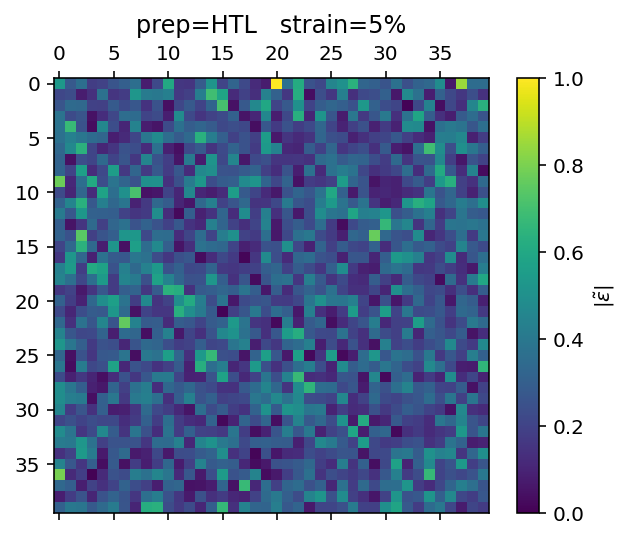

In [50]:
output = defaultdict(list)

fig, ax = plt.subplots(figsize=(5, 4))
colorbar = True

N = 40

for job in project:
    print(job)
    prep = job.sp["prep"]
    if prep != "HTL":
        continue
    print(prep)
    txt_prep = prep.lower()
    
    experiments = sorted(glob.glob(job.fn("aqs_therm_experiments/*/*/traj-fire_period-*.gsd")))
    inter_computer = InteractionComputer(experiments[0], job.sp["pot"], frame=0)
    if len(experiments) == 0:
        continue
    for exper in experiments:
        max_shear = utils.extract_between(exper, "max-shear-", "/")
        period = utils.extract_between(exper, "period-", ".gsd")
        temp = utils.extract_between(exper, "temp-", "/")
        df_path = f"aqs_therm_experiments/max-shear-{max_shear}/temp-{temp}/final-cycles-softness_period-{period}.parquet"
        sp = Statepoint(max_shear=float(max_shear), period=float(period), temp=float(temp), prep=prep)
        
        if float(period) != 1000.0 or float(temp) > 5e-3 or float(max_shear) != 0.05:
            continue

        if job.isfile(df_path):
            dataset = pl.read_parquet(job.fn(df_path), use_pyarrow=True)
        else:
            continue

        inter_computer.set_file(exper, frame=0)

        traj = gsd.hoomd.open(exper, "rb")

        old_frames = glob.glob(job.fn(f"videos/dev-stress-magv2-movie/dev-stress-magv2-movie-*.png"))
        for f in old_frames:
            os.remove(f)

        output_file = f"videos/dev-stress-magv2-movie-{txt_prep}_max-shear-{max_shear}_id-{job.id}.mp4"
        if os.path.exists(output_file):
            continue
        os.makedirs(job.fn("videos/dev-stress-magv2-movie"), exist_ok=True)

        name = r"$|\tilde{\epsilon}|$"

        for frame, _, soft in tqdm(dataset.rows()[:]):
            frame
            soft = np.array(soft)
            snap = traj[frame]
            box = snap.configuration.box
            square_box = np.array([box[0], box[1], 0, 0, 0, 0])
            freud_box = freud.box.Box.from_box(square_box)
            pos = freud_box.wrap(snap.particles.position)

            inter_computer.set_frame(frame)
            virials = inter_computer.get_virials()
            virials = virials.astype(np.float32)

            # norm = colors.Normalize(vmin=np.min(virial_trace), vmax=np.max(virial_trace))

            xx = locality.particle_to_grid_square_cic(
                pos[:, :2],
                virials[:, 0],
                box[0],
                N
            )

            yy = locality.particle_to_grid_square_cic(
                pos[:, :2],
                virials[:, 3],
                box[0],
                N
            )

            xy = locality.particle_to_grid_square_cic(
                pos[:, :2],
                virials[:, 1],
                box[0],
                N
            )

            diff = (xx - yy)/2
            dev_stress_mag = np.sqrt(xy**2 + diff**2)  # deviatoric stress magnitude

            clear_fig_and_plot_grid(ax, dev_stress_mag, norm, float(max_shear), prep, colorbar, name)
            output_name = job.fn(f"videos/dev-stress-magv2-movie/dev-stress-magv2-movie-{frame:04d}.png")
            colorbar = False

            plt.savefig(output_name, dpi=150)
        #     break
        # break
        import ffmpeg
        (
        ffmpeg
            .input(job.fn("videos/dev-stress-magv2-movie/dev-stress-magv2-movie-*.png"), pattern_type="glob", framerate=10)
            .output(output_file).run()
        )
    break

In [52]:
np.min(dev_stress_mag), np.max(dev_stress_mag)

(0.0043759346, 4.16861)

In [53]:
vmin = 0
vmax = 4
norm = colors.Normalize(vmin=vmin, vmax=vmax)
# vmin = 1e-2
# norm = colors.LogNorm(vmin=vmin, vmax=vmax)
# mshear = 0.08

634e14bc75836df75158fb15f379d8bb
7ec2f6aca035e69077eab24383a21cb6
ESL
Using pair function:  <function KA_LJ at 0x7fe5a4c7fac0>


100%|██████████| 201/201 [00:56<00:00,  3.58it/s]
ffmpeg version 4.2.2 Copyright (c) 2000-2019 the FFmpeg developers
  built with gcc 7.3.0 (crosstool-NG 1.23.0.449-a04d0)
  configuration: --prefix=/tmp/build/80754af9/ffmpeg_1587154242452/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placeho --cc=/tmp/build/80754af9/ffmpeg_1587154242452/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --enable-avresample --enable-gmp --enable-hardcoded-tables --enable-libfreetype --enable-libvpx --enable-pthreads --enable-libopus --enable-postproc --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame --disable-nonfree --enable-gpl --enable-gnutls --disable-openssl --enable-libopenh264 --enable-libx264
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58

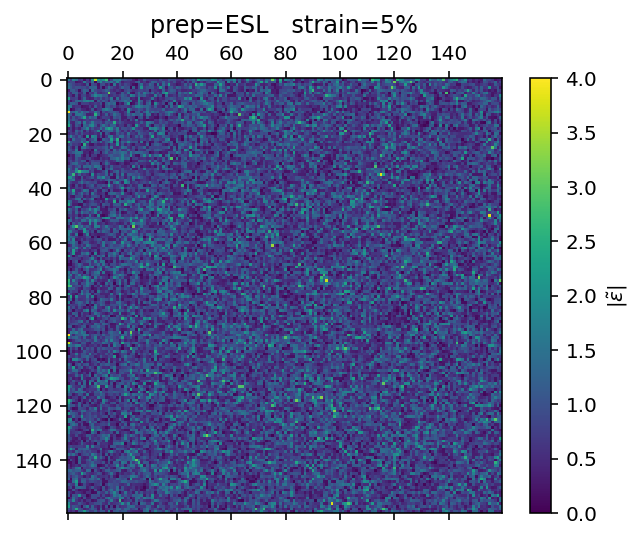

In [56]:
output = defaultdict(list)

fig, ax = plt.subplots(figsize=(5, 4))
colorbar = True

N = 160

for job in project:
    print(job)
    prep = job.sp["prep"]
    if prep != "ESL":
        continue
    print(prep)
    txt_prep = prep.lower()
    
    experiments = sorted(glob.glob(job.fn("aqs_therm_experiments/*/*/traj-fire_period-*.gsd")))
    inter_computer = InteractionComputer(experiments[0], job.sp["pot"], frame=0)
    if len(experiments) == 0:
        continue
    for exper in experiments:
        max_shear = utils.extract_between(exper, "max-shear-", "/")
        period = utils.extract_between(exper, "period-", ".gsd")
        temp = utils.extract_between(exper, "temp-", "/")
        df_path = f"aqs_therm_experiments/max-shear-{max_shear}/temp-{temp}/final-cycles-softness_period-{period}.parquet"
        sp = Statepoint(max_shear=float(max_shear), period=float(period), temp=float(temp), prep=prep)
        
        if float(period) != 1000.0 or float(temp) > 5e-3 or float(max_shear) != 0.05:
            continue

        if job.isfile(df_path):
            dataset = pl.read_parquet(job.fn(df_path), use_pyarrow=True)
        else:
            continue

        inter_computer.set_file(exper, frame=0)

        traj = gsd.hoomd.open(exper, "rb")

        old_frames = glob.glob(job.fn(f"videos/dev-stress-magv3-movie/dev-stress-magv3-movie-*.png"))
        for f in old_frames:
            os.remove(f)

        output_file = f"videos/dev-stress-magv3-movie-{txt_prep}_max-shear-{max_shear}_id-{job.id}.mp4"
        if os.path.exists(output_file):
            continue
        os.makedirs(job.fn("videos/dev-stress-magv3-movie"), exist_ok=True)

        name = r"$|\tilde{\epsilon}|$"

        for frame, _, soft in tqdm(dataset.rows()[:]):
            frame
            soft = np.array(soft)
            snap = traj[frame]
            box = snap.configuration.box
            square_box = np.array([box[0], box[1], 0, 0, 0, 0])
            freud_box = freud.box.Box.from_box(square_box)
            pos = freud_box.wrap(snap.particles.position)

            inter_computer.set_frame(frame)
            virials = inter_computer.get_virials()
            virials = virials.astype(np.float32)

            # norm = colors.Normalize(vmin=np.min(virial_trace), vmax=np.max(virial_trace))

            xx = locality.particle_to_grid_square_cic(
                pos[:, :2],
                virials[:, 0],
                box[0],
                N
            )

            yy = locality.particle_to_grid_square_cic(
                pos[:, :2],
                virials[:, 3],
                box[0],
                N
            )

            xy = locality.particle_to_grid_square_cic(
                pos[:, :2],
                virials[:, 1],
                box[0],
                N
            )

            diff = (xx - yy)/2
            dev_stress_mag = np.sqrt(xy**2 + diff**2)  # deviatoric stress magnitude

            clear_fig_and_plot_grid(ax, dev_stress_mag, norm, float(max_shear), prep, colorbar, name)
            output_name = job.fn(f"videos/dev-stress-magv3-movie/dev-stress-magv3-movie-{frame:04d}.png")
            colorbar = False

            plt.savefig(output_name, dpi=150)
        #     break
        # break
        import ffmpeg
        (
        ffmpeg
            .input(job.fn("videos/dev-stress-magv3-movie/dev-stress-magv3-movie-*.png"), pattern_type="glob", framerate=10)
            .output(output_file).run()
        )
    break

In [78]:
# def clear_fig_and_plot_hist2d(ax, x, y, norm, mshear, prep, colorbar=True, bins=100, name=""):
#     ax.clear()
#     # flip = x.T
#     # fig, ax = plt.subplots(figsize=(5, 4))
#     # cb = ax.matshow(flip, norm=norm, cmap="viridis")
#     ax.hist2d(x, y, bins=bins, norm=norm, cmap="viridis")
#     plt.title(f"prep={prep}   strain={mshear*100:.0f}%")
#     # if colorbar:
#     #     sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
#     #     plt.colorbar(sm, label=name, ax=ax)

def clear_fig_and_plot_hist2d(ax, x, y, norm, mshear, prep, colorbar=True, bins=100, name=""):
    ax.clear()
    flip = x.T
    # fig, ax = plt.subplots(figsize=(5, 4))
    cb = ax.matshow(x.T, norm=norm, cmap="viridis")
    levels = [-1, 0, 1]
    ax.contour(y.T, levels, origin='lower', linewidth=0.5, cmap="jet")
    
    plt.title(f"prep={prep}   strain={mshear*100:.0f}%")
    if colorbar:
        plt.colorbar(cb, label=name)

634e14bc75836df75158fb15f379d8bb
7ec2f6aca035e69077eab24383a21cb6
ESL
Using pair function:  <function KA_LJ at 0x7fe5a4c7fac0>


  0%|          | 0/40 [00:00<?, ?it/s]/tmp/ipykernel_2731647/2615144289.py:18: UserWarning: The following kwargs were not used by contour: 'linewidth'
  ax.contour(y.T, levels, origin='lower', linewidth=0.5, cmap="jet")
100%|██████████| 40/40 [00:13<00:00,  3.01it/s]
ffmpeg version 4.2.2 Copyright (c) 2000-2019 the FFmpeg developers
  built with gcc 7.3.0 (crosstool-NG 1.23.0.449-a04d0)
  configuration: --prefix=/tmp/build/80754af9/ffmpeg_1587154242452/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placeho --cc=/tmp/build/80754af9/ffmpeg_1587154242452/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --enable-avresample --enable-gmp --enable-hardcoded-tables --enable-libfreetype --enable-libvpx --enable-pthreads --enable-libopus --enable-postproc --enable-pic --enable-pthreads --enable-shared --enable-static --enable-v

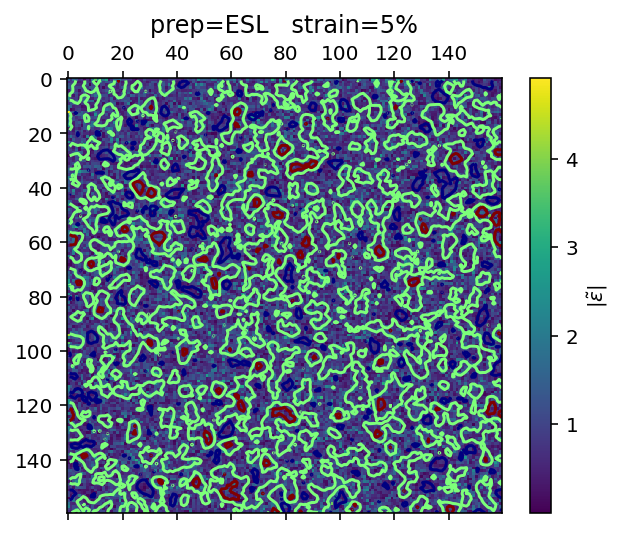

In [79]:
output = defaultdict(list)

fig, ax = plt.subplots(figsize=(5, 4))
colorbar = True

N = 160
bins = [np.linspace(0, 5, 25), np.linspace(-1, 1, 25)]

norm = colors.Normalize()

for job in project:
    print(job)
    prep = job.sp["prep"]
    if prep != "ESL":
        continue
    print(prep)
    txt_prep = prep.lower()
    
    experiments = sorted(glob.glob(job.fn("aqs_therm_experiments/*/*/traj-fire_period-*.gsd")))
    inter_computer = InteractionComputer(experiments[0], job.sp["pot"], frame=0)
    if len(experiments) == 0:
        continue
    for exper in experiments:
        max_shear = utils.extract_between(exper, "max-shear-", "/")
        period = utils.extract_between(exper, "period-", ".gsd")
        temp = utils.extract_between(exper, "temp-", "/")
        df_path = f"aqs_therm_experiments/max-shear-{max_shear}/temp-{temp}/final-cycles-softness_period-{period}.parquet"
        sp = Statepoint(max_shear=float(max_shear), period=float(period), temp=float(temp), prep=prep)
        
        if float(period) != 1000.0 or float(temp) > 5e-3 or float(max_shear) != 0.05:
            continue

        if job.isfile(df_path):
            dataset = pl.read_parquet(job.fn(df_path), use_pyarrow=True)
        else:
            continue

        inter_computer.set_file(exper, frame=0)

        traj = gsd.hoomd.open(exper, "rb")

        old_frames = glob.glob(job.fn(f"videos/dev-stress-softness-corr-movie/dev-stress-softness-corr-movie-*.png"))
        for f in old_frames:
            os.remove(f)

        output_file = f"videos/dev-stress-softness-corr-movie-{txt_prep}_max-shear-{max_shear}_id-{job.id}.mp4"
        
        if os.path.exists(output_file):
            os.remove(output_file)
        #     continue
        os.makedirs(job.fn("videos/dev-stress-softness-corr-movie"), exist_ok=True)

        name = r"$|\tilde{\epsilon}|$"

        corrs = []

        for frame, _, soft in tqdm(dataset.rows()[:][:40]):
            frame
            soft = np.array(soft)
            snap = traj[frame]
            box = snap.configuration.box
            square_box = np.array([box[0], box[1], 0, 0, 0, 0])
            freud_box = freud.box.Box.from_box(square_box)
            pos = freud_box.wrap(snap.particles.position)

            inter_computer.set_frame(frame)
            virials = inter_computer.get_virials()
            virials = virials.astype(np.float32)

            # norm = colors.Normalize(vmin=np.min(virial_trace), vmax=np.max(virial_trace))

            xx = locality.particle_to_grid_square_cic(
                pos[:, :2],
                virials[:, 0],
                box[0],
                N
            )

            yy = locality.particle_to_grid_square_cic(
                pos[:, :2],
                virials[:, 3],
                box[0],
                N
            )

            xy = locality.particle_to_grid_square_cic(
                pos[:, :2],
                virials[:, 1],
                box[0],
                N
            )

            diff = (xx - yy)/2
            dev_stress_mag = np.sqrt(xy**2 + diff**2)  # deviatoric stress magnitude

            softness = locality.particle_to_grid_square_cic(
                pos[:, :2],
                soft.astype(np.float32),
                box[0],
                N
            )

            # corrs.append(stats.pearsonr(grid.flatten(), softness.flatten())[0])

            clear_fig_and_plot_hist2d(ax, dev_stress_mag, softness, norm, float(max_shear), prep, colorbar, bins, name)
            output_name = job.fn(f"videos/dev-stress-softness-corr-movie/dev-stress-softness-corr-movie-{frame:04d}.png")
            colorbar = False

            plt.savefig(output_name, dpi=150)
        #     break
        # break
        import ffmpeg
        (
        ffmpeg
            .input(job.fn("videos/dev-stress-softness-corr-movie/dev-stress-softness-corr-movie-*.png"), pattern_type="glob", framerate=10)
            .output(output_file).run()
        )
    break

In [97]:
# def clear_fig_and_plot_hist2d(ax, x, y, norm, mshear, prep, colorbar=True, bins=100, name=""):
#     ax.clear()
#     # flip = x.T
#     # fig, ax = plt.subplots(figsize=(5, 4))
#     # cb = ax.matshow(flip, norm=norm, cmap="viridis")
#     ax.hist2d(x, y, bins=bins, norm=norm, cmap="viridis")
#     plt.title(f"prep={prep}   strain={mshear*100:.0f}%")
#     # if colorbar:
#     #     sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
#     #     plt.colorbar(sm, label=name, ax=ax)

import seaborn as sns

def clear_fig_and_plot_reg(ax, x, y, norm, mshear, prep, frame, colorbar=True, bins=100, name=""):
    # ax.clear()
    # flip = x.T
    # # fig, ax = plt.subplots(figsize=(5, 4))
    # cb = ax.matshow(x.T, norm=norm, cmap="viridis")
    # levels = [-1, 0, 1]
    # ax.contour(y.T, levels, origin='lower', linewidth=0.5, cmap="jet")
    
    # plt.title(f"prep={prep}   strain={mshear*100:.0f}%")
    # if colorbar:
    #     plt.colorbar(cb, label=name)
    ax.clear()
    plt.hist(x, bins=np.linspace(-2, 2, 20), density=True, alpha=0.5)
    sns.regplot(x=x, y=y, x_bins=np.linspace(-2, 2, 20), fit_reg=False, ax=ax)
    ax.set_xlabel("softness")
    ax.set_ylabel(name)
    ax.set_title(f"prep={prep}   strain={mshear*100:.0f}%   frame={frame:04d}")
    ax.set_ylim(0, 2)

634e14bc75836df75158fb15f379d8bb
7ec2f6aca035e69077eab24383a21cb6
ESL
Using pair function:  <function KA_LJ at 0x7fe5a4c7fac0>


  0%|          | 0/201 [00:00<?, ?it/s]

100%|██████████| 201/201 [02:55<00:00,  1.15it/s]
ffmpeg version 4.2.2 Copyright (c) 2000-2019 the FFmpeg developers
  built with gcc 7.3.0 (crosstool-NG 1.23.0.449-a04d0)
  configuration: --prefix=/tmp/build/80754af9/ffmpeg_1587154242452/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placeho --cc=/tmp/build/80754af9/ffmpeg_1587154242452/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --enable-avresample --enable-gmp --enable-hardcoded-tables --enable-libfreetype --enable-libvpx --enable-pthreads --enable-libopus --enable-postproc --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame --disable-nonfree --enable-gpl --enable-gnutls --disable-openssl --enable-libopenh264 --enable-libx264
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58

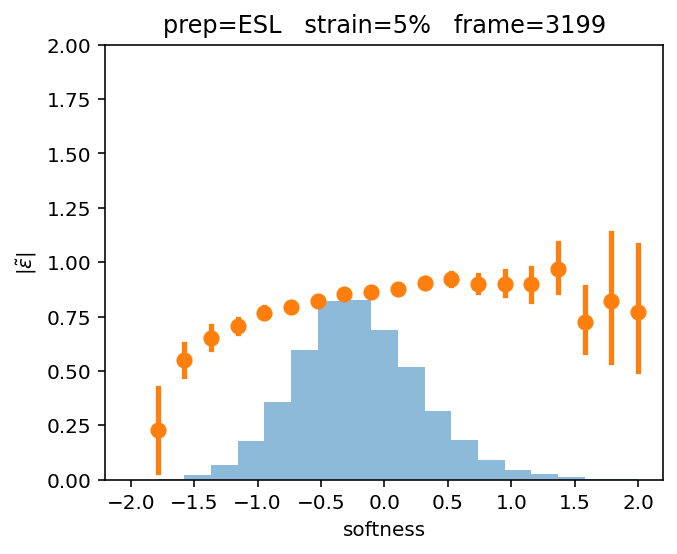

In [99]:
output = defaultdict(list)

fig, ax = plt.subplots(figsize=(5, 4))
colorbar = True

N = 160
bins = [np.linspace(0, 5, 25), np.linspace(-1, 1, 25)]

norm = colors.Normalize()

for job in project:
    print(job)
    prep = job.sp["prep"]
    if prep != "ESL":
        continue
    print(prep)
    txt_prep = prep.lower()
    
    experiments = sorted(glob.glob(job.fn("aqs_therm_experiments/*/*/traj-fire_period-*.gsd")))
    inter_computer = InteractionComputer(experiments[0], job.sp["pot"], frame=0)
    if len(experiments) == 0:
        continue
    for exper in experiments:
        max_shear = utils.extract_between(exper, "max-shear-", "/")
        period = utils.extract_between(exper, "period-", ".gsd")
        temp = utils.extract_between(exper, "temp-", "/")
        df_path = f"aqs_therm_experiments/max-shear-{max_shear}/temp-{temp}/final-cycles-softness_period-{period}.parquet"
        sp = Statepoint(max_shear=float(max_shear), period=float(period), temp=float(temp), prep=prep)
        
        if float(period) != 1000.0 or float(temp) > 5e-3 or float(max_shear) != 0.05:
            continue

        if job.isfile(df_path):
            dataset = pl.read_parquet(job.fn(df_path), use_pyarrow=True)
        else:
            continue

        inter_computer.set_file(exper, frame=0)

        traj = gsd.hoomd.open(exper, "rb")

        old_frames = glob.glob(job.fn(f"videos/dev-stress-softness-corr-movie/dev-stress-softness-corr-movie-*.png"))
        for f in old_frames:
            os.remove(f)

        output_file = f"videos/dev-stress-softness-corr-movie-{txt_prep}_max-shear-{max_shear}_id-{job.id}.mp4"
        
        if os.path.exists(output_file):
            os.remove(output_file)
        #     continue
        os.makedirs(job.fn("videos/dev-stress-softness-corr-movie"), exist_ok=True)

        name = r"$|\tilde{\epsilon}|$"

        corrs = []

        for frame, _, soft in tqdm(dataset.rows()[:]):
            frame
            soft = np.array(soft)
            snap = traj[frame]
            box = snap.configuration.box
            square_box = np.array([box[0], box[1], 0, 0, 0, 0])
            freud_box = freud.box.Box.from_box(square_box)
            pos = freud_box.wrap(snap.particles.position)

            inter_computer.set_frame(frame)
            virials = inter_computer.get_virials()
            virials = virials.astype(np.float32)

            # norm = colors.Normalize(vmin=np.min(virial_trace), vmax=np.max(virial_trace))

            xx = locality.particle_to_grid_square_cic(
                pos[:, :2],
                virials[:, 0],
                box[0],
                N
            )

            yy = locality.particle_to_grid_square_cic(
                pos[:, :2],
                virials[:, 3],
                box[0],
                N
            )

            xy = locality.particle_to_grid_square_cic(
                pos[:, :2],
                virials[:, 1],
                box[0],
                N
            )

            diff = (xx - yy)/2
            dev_stress_mag = np.sqrt(xy**2 + diff**2)  # deviatoric stress magnitude

            softness = locality.particle_to_grid_square_cic(
                pos[:, :2],
                soft.astype(np.float32),
                box[0],
                N
            )

            # corrs.append(stats.pearsonr(grid.flatten(), softness.flatten())[0])

            clear_fig_and_plot_reg(ax, softness.flatten(), dev_stress_mag.flatten(), norm, float(max_shear), prep, frame, colorbar, bins, name)
            output_name = job.fn(f"videos/dev-stress-softness-corr-movie/dev-stress-softness-corr-movie-{frame:04d}.png")
            colorbar = False

            plt.savefig(output_name, dpi=150)
        #     break
        # break
        import ffmpeg
        (
        ffmpeg
            .input(job.fn("videos/dev-stress-softness-corr-movie/dev-stress-softness-corr-movie-*.png"), pattern_type="glob", framerate=10)
            .output(output_file).run()
        )
    break

In [101]:
# def clear_fig_and_plot_hist2d(ax, x, y, norm, mshear, prep, colorbar=True, bins=100, name=""):
#     ax.clear()
#     # flip = x.T
#     # fig, ax = plt.subplots(figsize=(5, 4))
#     # cb = ax.matshow(flip, norm=norm, cmap="viridis")
#     ax.hist2d(x, y, bins=bins, norm=norm, cmap="viridis")
#     plt.title(f"prep={prep}   strain={mshear*100:.0f}%")
#     # if colorbar:
#     #     sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
#     #     plt.colorbar(sm, label=name, ax=ax)

import seaborn as sns

def clear_fig_and_plot_reg(ax, x, y, norm, mshear, prep, frame, colorbar=True, bins=100, name=""):
    # ax.clear()
    # flip = x.T
    # # fig, ax = plt.subplots(figsize=(5, 4))
    # cb = ax.matshow(x.T, norm=norm, cmap="viridis")
    # levels = [-1, 0, 1]
    # ax.contour(y.T, levels, origin='lower', linewidth=0.5, cmap="jet")
    
    # plt.title(f"prep={prep}   strain={mshear*100:.0f}%")
    # if colorbar:
    #     plt.colorbar(cb, label=name)
    ax.clear()
    plt.hist(x, bins=np.linspace(-2, 2, 20), density=True, alpha=0.5)
    sns.regplot(x=x, y=y, x_bins=np.linspace(-2, 2, 20), fit_reg=False, ax=ax)
    ax.set_xlabel("softness")
    ax.set_ylabel(name)
    ax.set_title(f"prep={prep}   strain={mshear*100:.0f}%   frame={frame:04d}")
    ax.set_ylim(-1, 1)

634e14bc75836df75158fb15f379d8bb
HTL
Using pair function:  <function KA_LJ at 0x7fe5a4c7fac0>


100%|██████████| 201/201 [02:55<00:00,  1.14it/s]
ffmpeg version 4.2.2 Copyright (c) 2000-2019 the FFmpeg developers
  built with gcc 7.3.0 (crosstool-NG 1.23.0.449-a04d0)
  configuration: --prefix=/tmp/build/80754af9/ffmpeg_1587154242452/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placeho --cc=/tmp/build/80754af9/ffmpeg_1587154242452/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --enable-avresample --enable-gmp --enable-hardcoded-tables --enable-libfreetype --enable-libvpx --enable-pthreads --enable-libopus --enable-postproc --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame --disable-nonfree --enable-gpl --enable-gnutls --disable-openssl --enable-libopenh264 --enable-libx264
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58

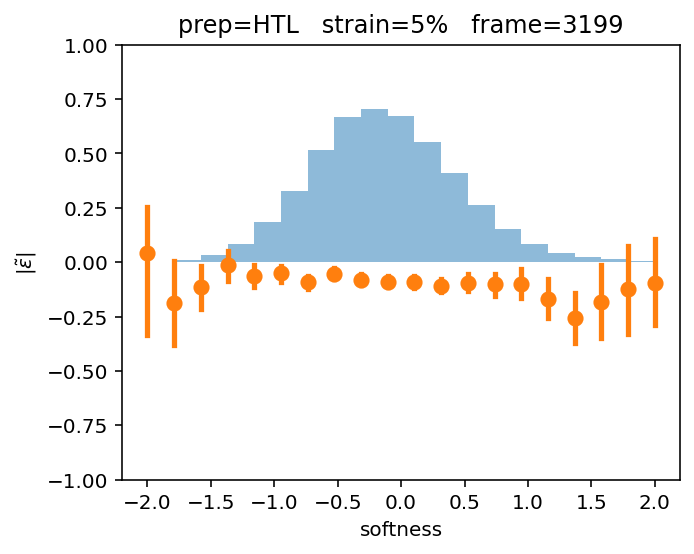

In [103]:
output = defaultdict(list)

fig, ax = plt.subplots(figsize=(5, 4))
colorbar = True

N = 160
bins = [np.linspace(0, 5, 25), np.linspace(-1, 1, 25)]

norm = colors.Normalize()

for job in project:
    print(job)
    prep = job.sp["prep"]
    if prep != "ESL":
        continue
    print(prep)
    txt_prep = prep.lower()
    
    experiments = sorted(glob.glob(job.fn("aqs_therm_experiments/*/*/traj-fire_period-*.gsd")))
    inter_computer = InteractionComputer(experiments[0], job.sp["pot"], frame=0)
    if len(experiments) == 0:
        continue
    for exper in experiments:
        max_shear = utils.extract_between(exper, "max-shear-", "/")
        period = utils.extract_between(exper, "period-", ".gsd")
        temp = utils.extract_between(exper, "temp-", "/")
        df_path = f"aqs_therm_experiments/max-shear-{max_shear}/temp-{temp}/final-cycles-softness_period-{period}.parquet"
        sp = Statepoint(max_shear=float(max_shear), period=float(period), temp=float(temp), prep=prep)
        
        if float(period) != 1000.0 or float(temp) > 5e-3 or float(max_shear) != 0.05:
            continue

        if job.isfile(df_path):
            dataset = pl.read_parquet(job.fn(df_path), use_pyarrow=True)
        else:
            continue

        inter_computer.set_file(exper, frame=0)

        traj = gsd.hoomd.open(exper, "rb")

        old_frames = glob.glob(job.fn(f"videos/dev-stress-softness-corr-movie/dev-stress-softness-corr-movie-*.png"))
        for f in old_frames:
            os.remove(f)

        output_file = f"videos/dev-stress-softness-corrv2-movie-{txt_prep}_max-shear-{max_shear}_id-{job.id}.mp4"
        
        if os.path.exists(output_file):
            os.remove(output_file)
        #     continue
        os.makedirs(job.fn("videos/dev-stress-softness-corr-movie"), exist_ok=True)

        name = r"$|\tilde{\epsilon}|$"

        corrs = []

        for frame, _, soft in tqdm(dataset.rows()[:]):
            frame
            soft = np.array(soft)
            snap = traj[frame]
            box = snap.configuration.box
            square_box = np.array([box[0], box[1], 0, 0, 0, 0])
            freud_box = freud.box.Box.from_box(square_box)
            pos = freud_box.wrap(snap.particles.position)

            inter_computer.set_frame(frame)
            virials = inter_computer.get_virials()
            virials = virials.astype(np.float32)

            # norm = colors.Normalize(vmin=np.min(virial_trace), vmax=np.max(virial_trace))

            # xx = locality.particle_to_grid_square_cic(
            #     pos[:, :2],
            #     virials[:, 0],
            #     box[0],
            #     N
            # )

            # yy = locality.particle_to_grid_square_cic(
            #     pos[:, :2],
            #     virials[:, 3],
            #     box[0],
            #     N
            # )

            xy = locality.particle_to_grid_square_cic(
                pos[:, :2],
                virials[:, 1],
                box[0],
                N
            )

            # diff = (xx - yy)/2
            # dev_stress_mag = np.sqrt(xy**2 + diff**2)  # deviatoric stress magnitude

            softness = locality.particle_to_grid_square_cic(
                pos[:, :2],
                soft.astype(np.float32),
                box[0],
                N
            )

            # corrs.append(stats.pearsonr(grid.flatten(), softness.flatten())[0])

            clear_fig_and_plot_reg(ax, softness.flatten(), xy.flatten(), norm, float(max_shear), prep, frame, colorbar, bins, name)
            output_name = job.fn(f"videos/dev-stress-softness-corr-movie/dev-stress-softness-corr-movie-{frame:04d}.png")
            colorbar = False

            plt.savefig(output_name, dpi=150)
        #     break
        # break
        import ffmpeg
        (
        ffmpeg
            .input(job.fn("videos/dev-stress-softness-corr-movie/dev-stress-softness-corr-movie-*.png"), pattern_type="glob", framerate=10)
            .output(output_file).run()
        )
    break

634e14bc75836df75158fb15f379d8bb
7ec2f6aca035e69077eab24383a21cb6
ESL
Using pair function:  <function KA_LJ at 0x7fe5a4c7fac0>


100%|██████████| 201/201 [02:54<00:00,  1.15it/s]
ffmpeg version 4.2.2 Copyright (c) 2000-2019 the FFmpeg developers
  built with gcc 7.3.0 (crosstool-NG 1.23.0.449-a04d0)
  configuration: --prefix=/tmp/build/80754af9/ffmpeg_1587154242452/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placeho --cc=/tmp/build/80754af9/ffmpeg_1587154242452/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --enable-avresample --enable-gmp --enable-hardcoded-tables --enable-libfreetype --enable-libvpx --enable-pthreads --enable-libopus --enable-postproc --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame --disable-nonfree --enable-gpl --enable-gnutls --disable-openssl --enable-libopenh264 --enable-libx264
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58

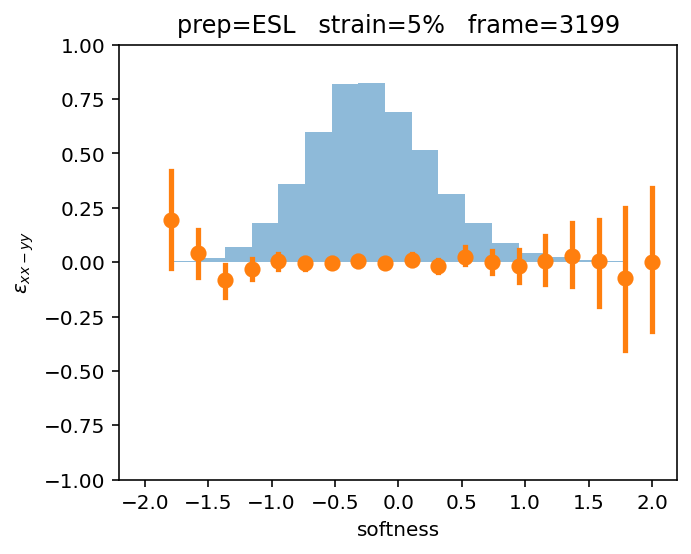

In [105]:
output = defaultdict(list)

fig, ax = plt.subplots(figsize=(5, 4))
colorbar = True

N = 160
bins = [np.linspace(0, 5, 25), np.linspace(-1, 1, 25)]

norm = colors.Normalize()

for job in project:
    print(job)
    prep = job.sp["prep"]
    if prep != "ESL":
        continue
    print(prep)
    txt_prep = prep.lower()
    
    experiments = sorted(glob.glob(job.fn("aqs_therm_experiments/*/*/traj-fire_period-*.gsd")))
    inter_computer = InteractionComputer(experiments[0], job.sp["pot"], frame=0)
    if len(experiments) == 0:
        continue
    for exper in experiments:
        max_shear = utils.extract_between(exper, "max-shear-", "/")
        period = utils.extract_between(exper, "period-", ".gsd")
        temp = utils.extract_between(exper, "temp-", "/")
        df_path = f"aqs_therm_experiments/max-shear-{max_shear}/temp-{temp}/final-cycles-softness_period-{period}.parquet"
        sp = Statepoint(max_shear=float(max_shear), period=float(period), temp=float(temp), prep=prep)
        
        if float(period) != 1000.0 or float(temp) > 5e-3 or float(max_shear) != 0.05:
            continue

        if job.isfile(df_path):
            dataset = pl.read_parquet(job.fn(df_path), use_pyarrow=True)
        else:
            continue

        inter_computer.set_file(exper, frame=0)

        traj = gsd.hoomd.open(exper, "rb")

        old_frames = glob.glob(job.fn(f"videos/dev-stress-softness-corr-movie/dev-stress-softness-corr-movie-*.png"))
        for f in old_frames:
            os.remove(f)

        output_file = f"videos/dev-stress-softness-corrv3-movie-{txt_prep}_max-shear-{max_shear}_id-{job.id}.mp4"
        
        if os.path.exists(output_file):
            os.remove(output_file)
        #     continue
        os.makedirs(job.fn("videos/dev-stress-softness-corr-movie"), exist_ok=True)

        name = r"$\epsilon_{xx-yy}$"

        corrs = []

        for frame, _, soft in tqdm(dataset.rows()[:]):
            frame
            soft = np.array(soft)
            snap = traj[frame]
            box = snap.configuration.box
            square_box = np.array([box[0], box[1], 0, 0, 0, 0])
            freud_box = freud.box.Box.from_box(square_box)
            pos = freud_box.wrap(snap.particles.position)

            inter_computer.set_frame(frame)
            virials = inter_computer.get_virials()
            virials = virials.astype(np.float32)

            # norm = colors.Normalize(vmin=np.min(virial_trace), vmax=np.max(virial_trace))

            xx = locality.particle_to_grid_square_cic(
                pos[:, :2],
                virials[:, 0],
                box[0],
                N
            )

            yy = locality.particle_to_grid_square_cic(
                pos[:, :2],
                virials[:, 3],
                box[0],
                N
            )

            # xy = locality.particle_to_grid_square_cic(
            #     pos[:, :2],
            #     virials[:, 1],
            #     box[0],
            #     N
            # )

            diff = (xx - yy)/2
            # dev_stress_mag = np.sqrt(xy**2 + diff**2)  # deviatoric stress magnitude

            softness = locality.particle_to_grid_square_cic(
                pos[:, :2],
                soft.astype(np.float32),
                box[0],
                N
            )

            # corrs.append(stats.pearsonr(grid.flatten(), softness.flatten())[0])

            clear_fig_and_plot_reg(ax, softness.flatten(), diff.flatten(), norm, float(max_shear), prep, frame, colorbar, bins, name)
            output_name = job.fn(f"videos/dev-stress-softness-corr-movie/dev-stress-softness-corr-movie-{frame:04d}.png")
            colorbar = False

            plt.savefig(output_name, dpi=150)
        #     break
        # break
        import ffmpeg
        (
        ffmpeg
            .input(job.fn("videos/dev-stress-softness-corr-movie/dev-stress-softness-corr-movie-*.png"), pattern_type="glob", framerate=10)
            .output(output_file).run()
        )
    break

634e14bc75836df75158fb15f379d8bb
7ec2f6aca035e69077eab24383a21cb6
ESL
Using pair function:  <function KA_LJ at 0x7fe5a4c7fac0>


100%|██████████| 40/40 [00:03<00:00, 11.44it/s]


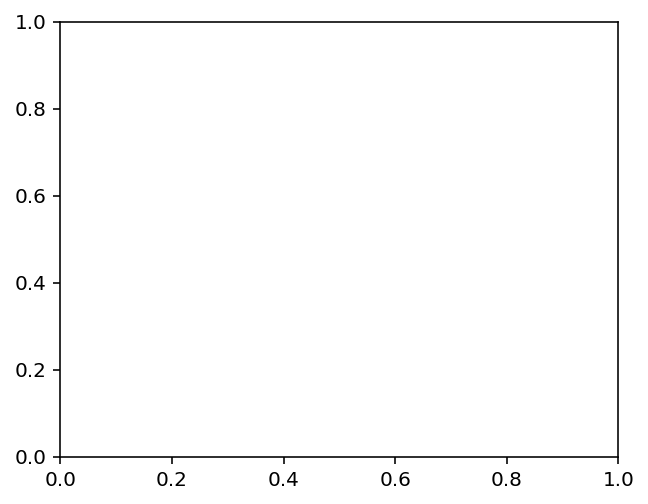

In [285]:
output = defaultdict(list)

fig, ax = plt.subplots(figsize=(5, 4))
colorbar = True

N = 160
bins = [np.linspace(0, 5, 25), np.linspace(-1, 1, 25)]

norm = colors.Normalize()

for job in project:
    print(job)
    prep = job.sp["prep"]
    if prep != "ESL":
        continue
    print(prep)
    txt_prep = prep.lower()
    
    experiments = sorted(glob.glob(job.fn("aqs_therm_experiments/*/*/traj-fire_period-*.gsd")))
    inter_computer = InteractionComputer(experiments[0], job.sp["pot"], frame=0)
    if len(experiments) == 0:
        continue
    for exper in experiments:
        max_shear = utils.extract_between(exper, "max-shear-", "/")
        period = utils.extract_between(exper, "period-", ".gsd")
        temp = utils.extract_between(exper, "temp-", "/")
        df_path = f"aqs_therm_experiments/max-shear-{max_shear}/temp-{temp}/final-cycles-softness_period-{period}.parquet"
        sp = Statepoint(max_shear=float(max_shear), period=float(period), temp=float(temp), prep=prep)
        
        if float(period) != 1000.0 or float(temp) > 5e-3 or float(max_shear) != 0.02:
            continue

        if job.isfile(df_path):
            dataset = pl.read_parquet(job.fn(df_path), use_pyarrow=True)
        else:
            continue

        inter_computer.set_file(exper, frame=0)

        traj = gsd.hoomd.open(exper, "rb")

        old_frames = glob.glob(job.fn(f"videos/dev-stress-softness-corr-movie/dev-stress-softness-corr-movie-*.png"))
        for f in old_frames:
            os.remove(f)

        output_file = f"videos/dev-stress-softness-corrv3-movie-{txt_prep}_max-shear-{max_shear}_id-{job.id}.mp4"
        
        if os.path.exists(output_file):
            os.remove(output_file)
        #     continue
        os.makedirs(job.fn("videos/dev-stress-softness-corr-movie"), exist_ok=True)

        name = r"$\epsilon_{xx-yy}$"

        xs = []
        ys = []
        zs = []

        frame0 = dataset[0]["frame"].to_numpy()[0]
        snap0 = traj[int(frame0)]

        neigh_query = freud.locality.AABBQuery.from_system(snap0)
        nlist = neigh_query.query(snap0.particles.position, {"num_neighbors": 10}).toNeighborList()

        for frame, _, soft in tqdm(dataset.rows()[:40]):
            frame
            soft = np.array(soft)
            snap = traj[frame]
            box = snap.configuration.box
            square_box = np.array([box[0], box[1], 0, 0, 0, 0])
            freud_box = freud.box.Box.from_box(square_box)
            pos = freud_box.wrap(snap.particles.position)

            inter_computer.set_frame(frame)
            virials = inter_computer.get_virials()
            virials = virials.astype(np.float32)

            # norm = colors.Normalize(vmin=np.min(virial_trace), vmax=np.max(virial_trace))

            # xx = locality.particle_to_grid_square_cic(
            #     pos[:, :2],
            #     virials[:, 0],
            #     box[0],
            #     N
            # )
            xx = virials[:, 0]
            yy = virials[:, 3]

            # yy = locality.particle_to_grid_square_cic(
            #     pos[:, :2],
            #     virials[:, 3],
            #     box[0],
            #     N
            # )

            # xy = locality.particle_to_grid_square_cic(
            #     pos[:, :2],
            #     virials[:, 1],
            #     box[0],
            #     N
            # )
            xy = virials[:, 1]

            diff = (xx - yy)/2
            # dev_stress_mag = np.sqrt(xy**2 + diff**2)  # deviatoric stress magnitude

            # softness = locality.particle_to_grid_square_cic(
            #     pos[:, :2],
            #     soft.astype(np.float32),
            #     box[0],
            #     N
            # )
            softness = soft

            xs.append(xy)
            ys.append(diff)
            zs.append(softness)

            # corrs.append(stats.pearsonr(grid.flatten(), softness.flatten())[0])

            # clear_fig_and_plot_reg(ax, softness.flatten(), diff.flatten(), norm, float(max_shear), prep, frame, colorbar, bins, name)
            # output_name = job.fn(f"videos/dev-stress-softness-corr-movie/dev-stress-softness-corr-movie-{frame:04d}.png")
            # colorbar = False

            # plt.savefig(output_name, dpi=150)
        #     break
        break
        # import ffmpeg
        # (
        # ffmpeg
        #     .input(job.fn("videos/dev-stress-softness-corr-movie/dev-stress-softness-corr-movie-*.png"), pattern_type="glob", framerate=10)
        #     .output(output_file).run()
        # )
    break

In [286]:
xs = np.array(xs)
ys = np.array(ys)
zs = np.array(zs)

In [288]:
seg = nlist.segments[0]
nn = nlist.neighbor_counts[0]
nlist.point_indices[seg:seg+nn]

array([    0,   677,   891,  2346,  3495,  6729, 26939, 27998, 31242,
       32396], dtype=uint32)

In [284]:
dir(nlist.toNeighborList())

['__class__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__len__',
 '__lt__',
 '__ne__',
 '__new__',
 '__pyx_vtable__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 'copy',
 'distances',
 'filter',
 'filter_r',
 'find_first_index',
 'from_arrays',
 'neighbor_counts',
 'num_points',
 'num_query_points',
 'point_indices',
 'query_point_indices',
 'segments',
 'weights']

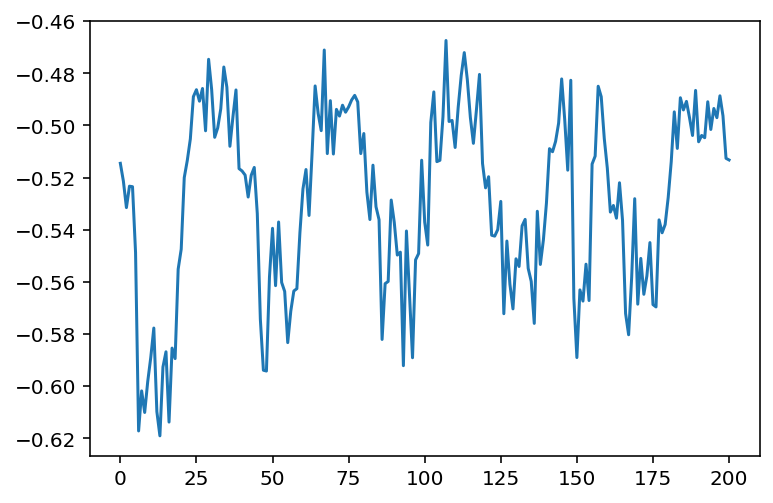

In [224]:
plt.plot(-zs[:, 0])

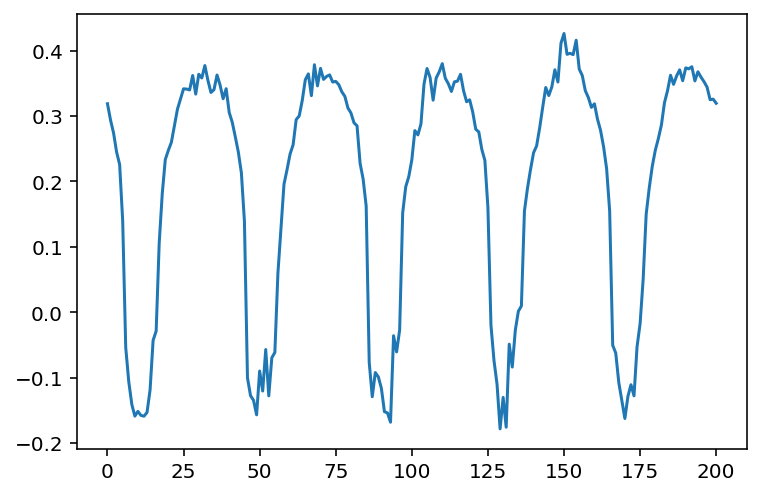

In [226]:
plt.plot(xs[:, 0])

In [230]:
dev_mag = np.sqrt(xs**2 + ys**2)

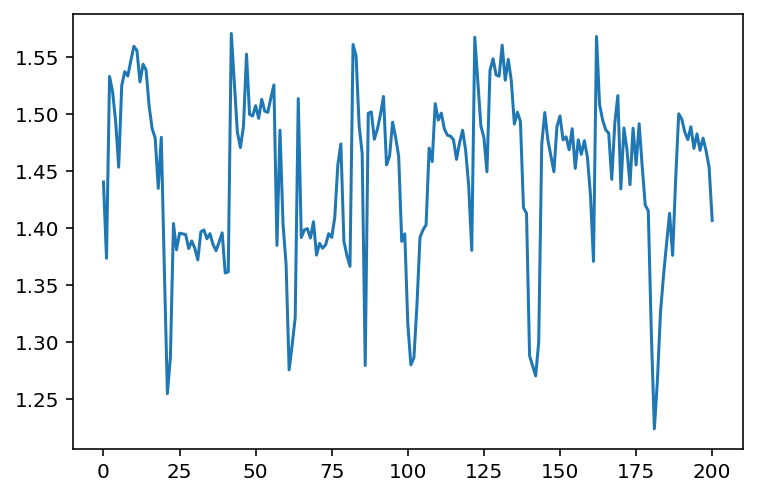

In [187]:
plt.plot(dev_mag[:, 1])

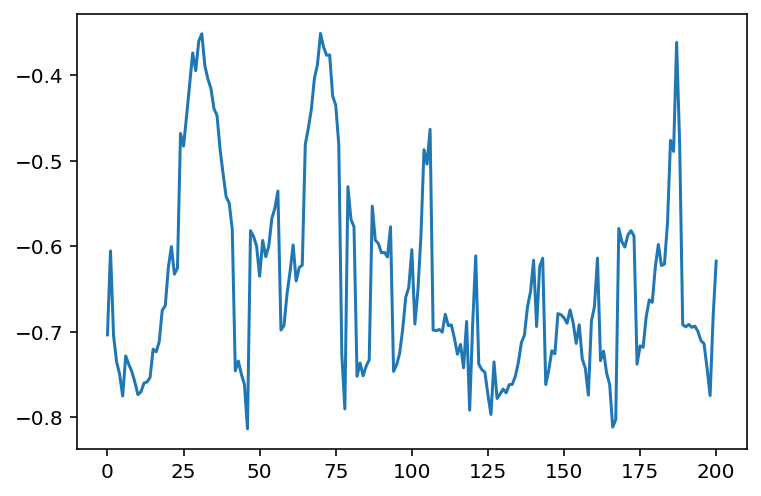

In [188]:
plt.plot(zs[:, 1])

In [189]:
i = 3

In [190]:
strain = np.sin(np.linspace(0, 2*np.pi*len(xs)/40, len(xs)))

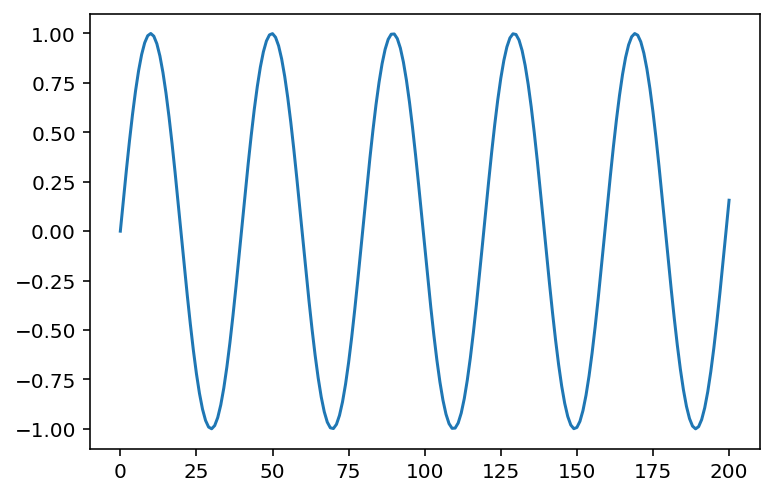

In [191]:
plt.plot(strain)

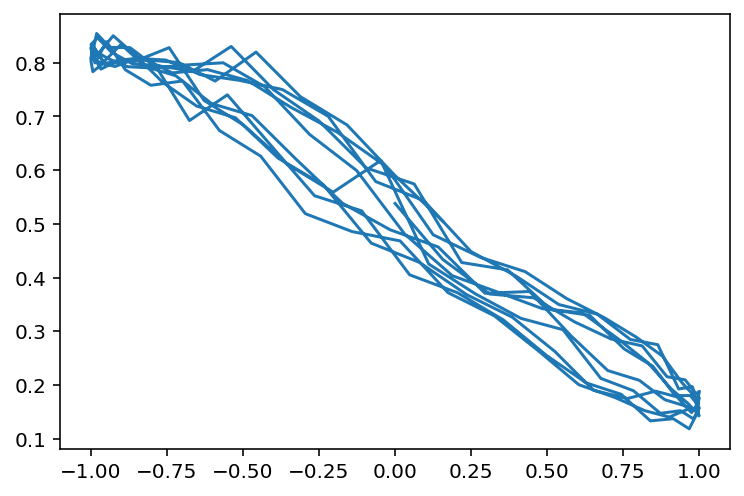

In [192]:
plt.plot(strain, xs[:, 2], label="xy")

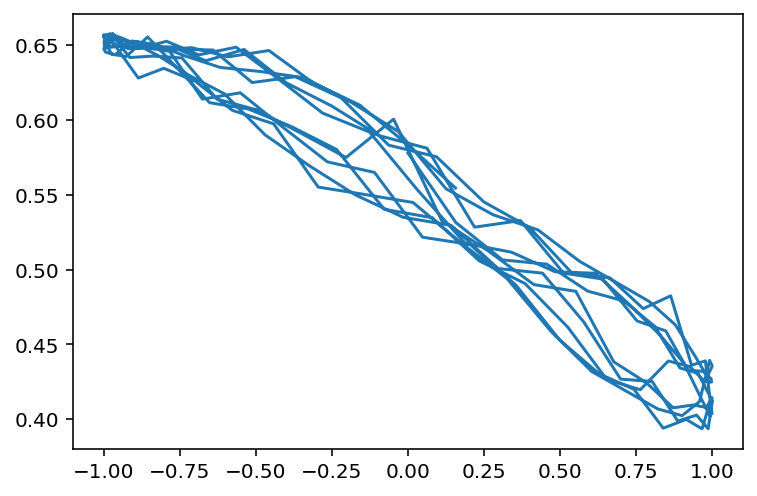

In [194]:
plt.plot(strain, ys[:, 2], label="xx - yy")

Text(0.5, 1.0, 'corr=-0.98  soft=-0.05')

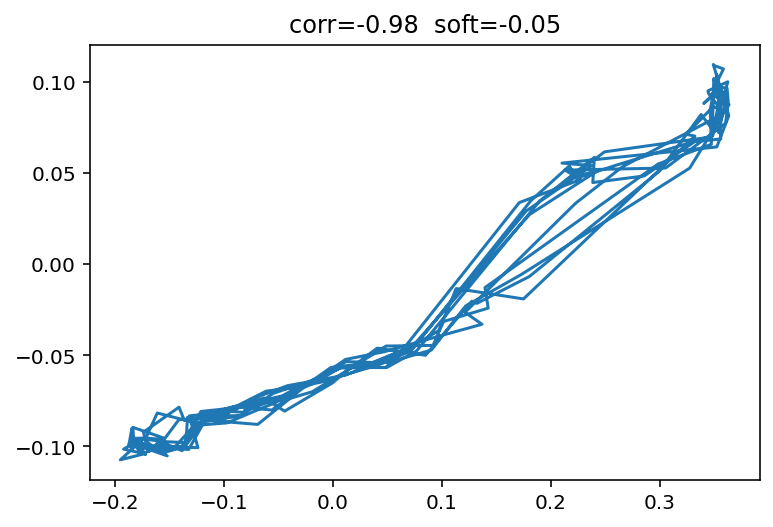

In [267]:
i = 14
corr = stats.pearsonr(-zs[:, i], xs[:, i])
soft = np.mean(zs[:, i])
plt.plot(-zs[:, i], -xs[:, i], "-", label="xx - yy")
plt.title(f"corr={corr[0]:.2f}  soft={soft:.2f}")

In [207]:
i=5

In [208]:
xs[0,i]

2.4320035

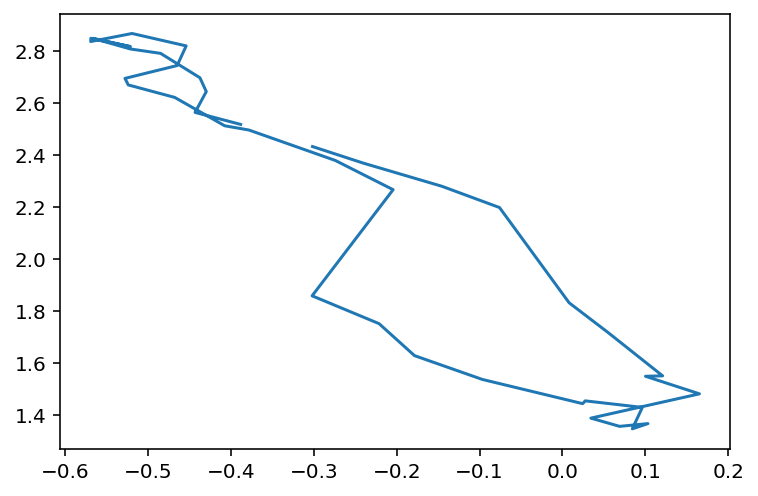

In [209]:
plt.plot(-zs[:40,i], xs[:40,i], "-")

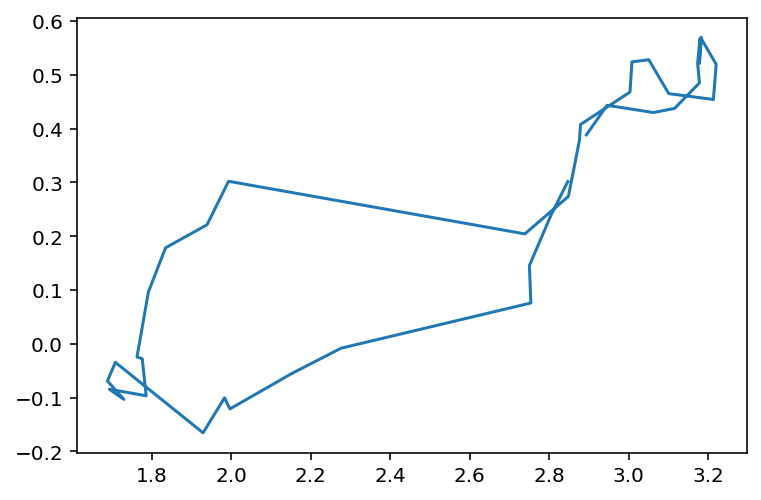

In [210]:
plt.plot(dev_mag[:40,i], zs[:40,i], "-")

In [33]:
def clear_fig_and_plot_grid(ax, grid, norm, mshear, prep, colorbar=True, name=""):
    ax.clear()
    flip = grid.T
    # fig, ax = plt.subplots(figsize=(5, 4))
    cb = ax.matshow(flip, norm=norm, cmap="hsv")
    plt.title(f"prep={prep}   strain={mshear*100:.0f}%")
    if colorbar:
        plt.colorbar(cb, label=name)

In [34]:
vmin = -np.pi
vmax = np.pi
norm = colors.Normalize(vmin=vmin, vmax=vmax)
# norm = colors.LogNorm(vmin=vmin, vmax=vmax)
# mshear = 0.08

634e14bc75836df75158fb15f379d8bb
7ec2f6aca035e69077eab24383a21cb6
ESL
Using pair function:  <function KA_LJ at 0x7027028d3ac0>


100%|██████████| 201/201 [00:53<00:00,  3.74it/s]
ffmpeg version 4.2.2 Copyright (c) 2000-2019 the FFmpeg developers
  built with gcc 7.3.0 (crosstool-NG 1.23.0.449-a04d0)
  configuration: --prefix=/tmp/build/80754af9/ffmpeg_1587154242452/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placeho --cc=/tmp/build/80754af9/ffmpeg_1587154242452/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --enable-avresample --enable-gmp --enable-hardcoded-tables --enable-libfreetype --enable-libvpx --enable-pthreads --enable-libopus --enable-postproc --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame --disable-nonfree --enable-gpl --enable-gnutls --disable-openssl --enable-libopenh264 --enable-libx264
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58

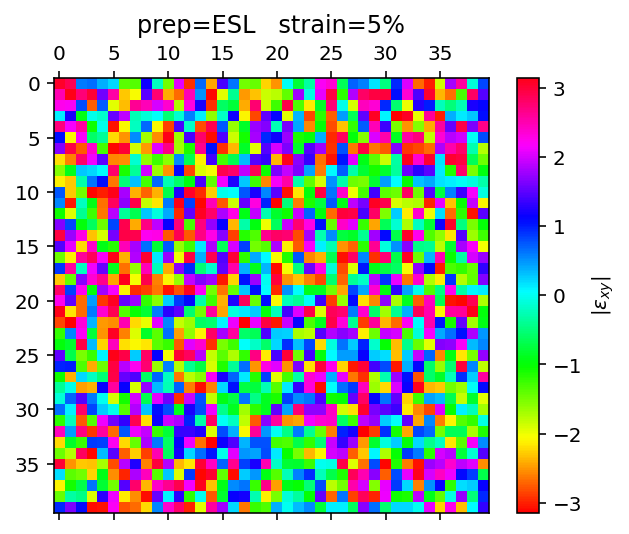

In [38]:
output = defaultdict(list)

fig, ax = plt.subplots(figsize=(5, 4))
colorbar = True

N = 40

for job in project:
    print(job)
    prep = job.sp["prep"]
    if prep != "ESL":
        continue
    print(prep)
    txt_prep = prep.lower()
    
    experiments = sorted(glob.glob(job.fn("aqs_therm_experiments/*/*/traj-fire_period-*.gsd")))
    inter_computer = InteractionComputer(experiments[0], job.sp["pot"], frame=0)
    if len(experiments) == 0:
        continue
    for exper in experiments:
        max_shear = utils.extract_between(exper, "max-shear-", "/")
        period = utils.extract_between(exper, "period-", ".gsd")
        temp = utils.extract_between(exper, "temp-", "/")
        df_path = f"aqs_therm_experiments/max-shear-{max_shear}/temp-{temp}/final-cycles-softness_period-{period}.parquet"
        sp = Statepoint(max_shear=float(max_shear), period=float(period), temp=float(temp), prep=prep)
        
        if float(period) != 1000.0 or float(temp) > 5e-3 or float(max_shear) != 0.05:
            continue

        if job.isfile(df_path):
            dataset = pl.read_parquet(job.fn(df_path), use_pyarrow=True)
        else:
            continue

        inter_computer.set_file(exper, frame=0)

        traj = gsd.hoomd.open(exper, "rb")

        old_frames = glob.glob(job.fn(f"videos/dev-stress-comp-movie/dev-stress-comp-movie-*.png"))
        for f in old_frames:
            os.remove(f)

        output_file = f"videos/dev-stress-comp-anglev2-movie-{txt_prep}_max-shear-{max_shear}_id-{job.id}.mp4"
        if os.path.exists(output_file):
            continue
        os.makedirs(job.fn("videos/dev-stress-comp-movie"), exist_ok=True)

        name = r"$|\epsilon_{xy}|$"

        for frame, _, soft in tqdm(dataset.rows()[:]):
            frame
            soft = np.array(soft)
            snap = traj[frame]
            box = snap.configuration.box
            square_box = np.array([box[0], box[1], 0, 0, 0, 0])
            freud_box = freud.box.Box.from_box(square_box)
            pos = freud_box.wrap(snap.particles.position)

            inter_computer.set_frame(frame)
            virials = inter_computer.get_virials()
            virials = virials.astype(np.float32)

            # norm = colors.Normalize(vmin=np.min(virial_trace), vmax=np.max(virial_trace))

            xx = locality.particle_to_grid_square_cic(
                pos[:, :2],
                virials[:, 0],
                box[0],
                N
            )

            yy = locality.particle_to_grid_square_cic(
                pos[:, :2],
                virials[:, 3],
                box[0],
                N
            )

            xy = locality.particle_to_grid_square_cic(
                pos[:, :2],
                virials[:, 1],
                box[0],
                N
            )

            xy = (xy - np.mean(xy))/np.std(xy)

            diff = (xx - yy)/2
            diff = (diff - np.mean(diff))/np.std(diff)
            # dev_stress_mag = np.sqrt(xy**2 + diff**2)  # deviatoric stress
            # magnitude
            angle = np.arctan2(xy, diff)

            clear_fig_and_plot_grid(ax, angle, norm, float(max_shear), prep, colorbar, name)
            output_name = job.fn(f"videos/dev-stress-comp-movie/dev-stress-comp-movie-{frame:04d}.png")
            colorbar = False

            plt.savefig(output_name, dpi=150)
        #     break
        # break
        import ffmpeg
        (
        ffmpeg
            .input(job.fn("videos/dev-stress-comp-movie/dev-stress-comp-movie-*.png"), pattern_type="glob", framerate=10)
            .output(output_file).run()
        )
    break

634e14bc75836df75158fb15f379d8bb
HTL
Using pair function:  <function KA_LJ at 0x7027028d3ac0>


100%|██████████| 201/201 [00:36<00:00,  5.47it/s]
ffmpeg version 4.2.2 Copyright (c) 2000-2019 the FFmpeg developers
  built with gcc 7.3.0 (crosstool-NG 1.23.0.449-a04d0)
  configuration: --prefix=/tmp/build/80754af9/ffmpeg_1587154242452/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placeho --cc=/tmp/build/80754af9/ffmpeg_1587154242452/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --enable-avresample --enable-gmp --enable-hardcoded-tables --enable-libfreetype --enable-libvpx --enable-pthreads --enable-libopus --enable-postproc --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame --disable-nonfree --enable-gpl --enable-gnutls --disable-openssl --enable-libopenh264 --enable-libx264
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58

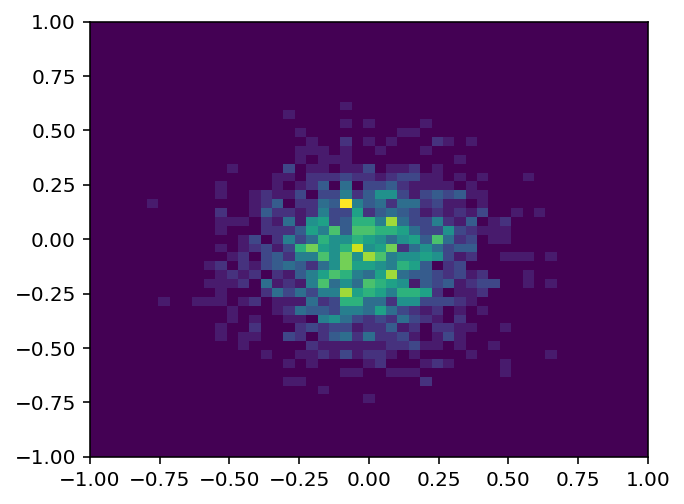

In [55]:
output = defaultdict(list)

fig, ax = plt.subplots(figsize=(5, 4))
colorbar = True

N = 40

for job in project:
    print(job)
    prep = job.sp["prep"]
    if prep != "HTL":
        continue
    print(prep)
    txt_prep = prep.lower()
    
    experiments = sorted(glob.glob(job.fn("aqs_therm_experiments/*/*/traj-fire_period-*.gsd")))
    inter_computer = InteractionComputer(experiments[0], job.sp["pot"], frame=0)
    if len(experiments) == 0:
        continue
    for exper in experiments:
        max_shear = utils.extract_between(exper, "max-shear-", "/")
        period = utils.extract_between(exper, "period-", ".gsd")
        temp = utils.extract_between(exper, "temp-", "/")
        df_path = f"aqs_therm_experiments/max-shear-{max_shear}/temp-{temp}/final-cycles-softness_period-{period}.parquet"
        sp = Statepoint(max_shear=float(max_shear), period=float(period), temp=float(temp), prep=prep)
        
        if float(period) != 1000.0 or float(temp) > 5e-3 or float(max_shear) != 0.05:
            continue

        if job.isfile(df_path):
            dataset = pl.read_parquet(job.fn(df_path), use_pyarrow=True)
        else:
            continue

        inter_computer.set_file(exper, frame=0)

        traj = gsd.hoomd.open(exper, "rb")

        old_frames = glob.glob(job.fn(f"videos/dev-stress-comp-movie/dev-stress-comp-movie-*.png"))
        for f in old_frames:
            os.remove(f)

        output_file = f"videos/dev-stress-comp-anglev3-movie-{txt_prep}_max-shear-{max_shear}_id-{job.id}.mp4"
        if os.path.exists(output_file):
            # print("hey")
            continue
        os.makedirs(job.fn("videos/dev-stress-comp-movie"), exist_ok=True)

        name = r"$|\epsilon_{xy}|$"

        for frame, _, soft in tqdm(dataset.rows()[:]):
            frame
            soft = np.array(soft)
            snap = traj[frame]
            box = snap.configuration.box
            square_box = np.array([box[0], box[1], 0, 0, 0, 0])
            freud_box = freud.box.Box.from_box(square_box)
            pos = freud_box.wrap(snap.particles.position)

            inter_computer.set_frame(frame)
            virials = inter_computer.get_virials()
            virials = virials.astype(np.float32)

            # norm = colors.Normalize(vmin=np.min(virial_trace), vmax=np.max(virial_trace))

            xx = locality.particle_to_grid_square_cic(
                pos[:, :2],
                virials[:, 0],
                box[0],
                N
            )

            yy = locality.particle_to_grid_square_cic(
                pos[:, :2],
                virials[:, 3],
                box[0],
                N
            )

            xy = locality.particle_to_grid_square_cic(
                pos[:, :2],
                virials[:, 1],
                box[0],
                N
            )

            # xy = (xy - np.mean(xy))/np.std(xy)

            diff = (xx - yy)/2
            # diff = (diff - np.mean(diff))/np.std(diff)
            # dev_stress_mag = np.sqrt(xy**2 + diff**2)  # deviatoric stress
            # magnitude
            # angle = np.arctan2(xy, diff)

            softness = locality.particle_to_grid_square_cic(
                pos[:, :2],
                soft.astype(np.float32),
                box[0],
                N
            )

            bins = np.linspace(-1, 1, 50)
            ax.clear()
            ax.hist2d(diff.flatten(), xy.flatten(), bins=bins)

            # clear_fig_and_plot_grid(ax, angle, norm, float(max_shear), prep, colorbar, name)
            output_name = job.fn(f"videos/dev-stress-comp-movie/dev-stress-comp-movie-{frame:04d}.png")
            colorbar = False

            plt.savefig(output_name, dpi=150)
        #     break
        # break
        import ffmpeg
        (
        ffmpeg
            .input(job.fn("videos/dev-stress-comp-movie/dev-stress-comp-movie-*.png"), pattern_type="glob", framerate=10)
            .output(output_file).run()
        )
    break

634e14bc75836df75158fb15f379d8bb
HTL
Using pair function:  <function KA_LJ at 0x7027028d3ac0>
hey


100%|██████████| 40/40 [00:58<00:00,  1.46s/it]


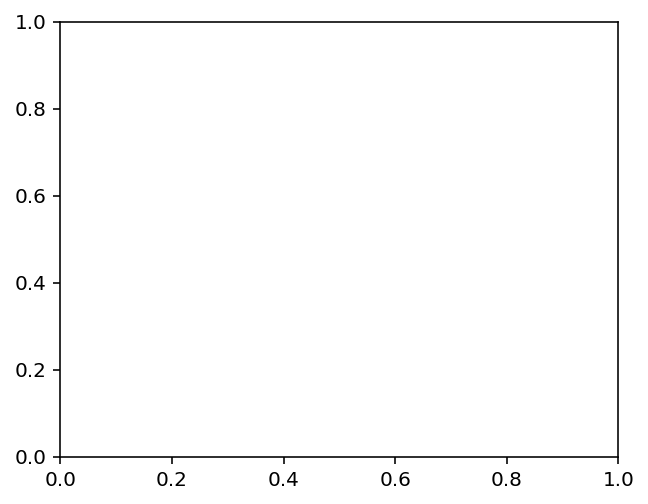

In [73]:
output = defaultdict(list)

fig, ax = plt.subplots(figsize=(5, 4))
colorbar = True

N = 40

for job in project:
    print(job)
    prep = job.sp["prep"]
    if prep != "HTL":
        continue
    print(prep)
    txt_prep = prep.lower()
    
    experiments = sorted(glob.glob(job.fn("aqs_therm_experiments/*/*/traj-fire_period-*.gsd")))
    inter_computer = InteractionComputer(experiments[0], job.sp["pot"], frame=0)
    if len(experiments) == 0:
        continue
    for exper in experiments:
        max_shear = utils.extract_between(exper, "max-shear-", "/")
        period = utils.extract_between(exper, "period-", ".gsd")
        temp = utils.extract_between(exper, "temp-", "/")
        df_path = f"aqs_therm_experiments/max-shear-{max_shear}/temp-{temp}/final-cycles-softness_period-{period}.parquet"
        sp = Statepoint(max_shear=float(max_shear), period=float(period), temp=float(temp), prep=prep)
        
        if float(period) != 1000.0 or float(temp) > 5e-3 or float(max_shear) != 0.05:
            continue

        if job.isfile(df_path):
            dataset = pl.read_parquet(job.fn(df_path), use_pyarrow=True)
        else:
            continue

        inter_computer.set_file(exper, frame=0)

        traj = gsd.hoomd.open(exper, "rb")

        old_frames = glob.glob(job.fn(f"videos/dev-stress-comp-movie/dev-stress-comp-movie-*.png"))
        for f in old_frames:
            os.remove(f)

        output_file = f"videos/dev-stress-comp-anglev3-movie-{txt_prep}_max-shear-{max_shear}_id-{job.id}.mp4"
        if os.path.exists(output_file):
            print("hey")
            # continue
        os.makedirs(job.fn("videos/dev-stress-comp-movie"), exist_ok=True)

        x = []
        y = []
        z = []

        name = r"$|\epsilon_{xy}|$"
        first = True
        for frame, _, soft in tqdm(dataset.rows()[:40]):
            frame
            soft = np.array(soft)
            snap = traj[frame]
            box = snap.configuration.box
            square_box = np.array([box[0], box[1], 0, 0, 0, 0])
            freud_box = freud.box.Box.from_box(square_box)
            pos = freud_box.wrap(snap.particles.position)

            if first:
                aabb_query = freud.locality.AABBQuery.from_system(snap)
                nlist = aabb_query.query(snap.particles.position, {"num_neighbors": 20}).toNeighborList()
            

            inter_computer.set_frame(frame)
            virials = inter_computer.get_virials()
            virials = virials.astype(np.float32)

            nvirials = np.zeros_like(virials)
            nsoftness = np.zeros_like(soft)
            for idx, (seg, nn) in enumerate(zip(nlist.segments, nlist.neighbor_counts)):
                points = nlist.point_indices[seg:seg+nn]
                nvirials[idx] = np.mean(virials[points], axis=0)
                nsoftness[idx] = np.mean(soft[points], axis=0)

            xx = nvirials[:, 0]
            yy = nvirials[:, 3]
            xy = nvirials[:, 1]
            diff = (xx - yy)/2
            x.append(xy)
            y.append(diff)
            z.append(nsoftness)
            # norm = colors.Normalize(vmin=np.min(virial_trace), vmax=np.max(virial_trace))

            # xx = locality.particle_to_grid_square_cic(
            #     pos[:, :2],
            #     virials[:, 0],
            #     box[0],
            #     N
            # )

            # yy = locality.particle_to_grid_square_cic(
            #     pos[:, :2],
            #     virials[:, 3],
            #     box[0],
            #     N
            # )

            # xy = locality.particle_to_grid_square_cic(
            #     pos[:, :2],
            #     virials[:, 1],
            #     box[0],
            #     N
            # )

            # xy = (xy - np.mean(xy))/np.std(xy)

            # diff = (xx - yy)/2
            # diff = (diff - np.mean(diff))/np.std(diff)
            # dev_stress_mag = np.sqrt(xy**2 + diff**2)  # deviatoric stress
            # magnitude
            # angle = np.arctan2(xy, diff)

            # softness = locality.particle_to_grid_square_cic(
            #     pos[:, :2],
            #     soft.astype(np.float32),
            #     box[0],
            #     N
            # )

            # bins = np.linspace(-1, 1, 50)
            # ax.clear()
            # ax.hist2d(diff.flatten(), xy.flatten(), bins=bins)

            # # clear_fig_and_plot_grid(ax, angle, norm, float(max_shear), prep, colorbar, name)
            # output_name = job.fn(f"videos/dev-stress-comp-movie/dev-stress-comp-movie-{frame:04d}.png")
            # colorbar = False

            # plt.savefig(output_name, dpi=150)
            # break
        # plt.plot(x, y, "-")
        break
        import ffmpeg
        (
        ffmpeg
            .input(job.fn("videos/dev-stress-comp-movie/dev-stress-comp-movie-*.png"), pattern_type="glob", framerate=10)
            .output(output_file).run()
        )
    break

In [76]:
x = np.array(x)
y = np.array(y)
z = np.array(z)

In [83]:
plt.ion()

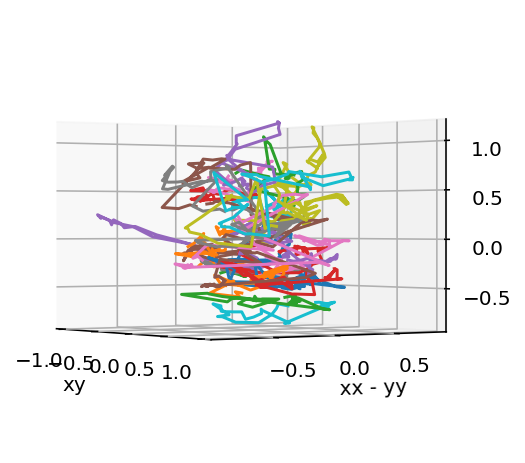

In [89]:
ax = plt.figure().add_subplot(projection='3d')
for idx in range(30):
    ax.plot(x[:, idx], y[:, idx], z[:, idx], "-")
ax.view_init(elev=0., azim=-35, roll=0)
# plt.plot(x[:, idx], y[:, idx], "-")
ax.set_xlabel("xy")
ax.set_ylabel("xx - yy")
ax.set_zlabel("softness")
plt.show()